In [1]:
# 必要なモジュールをインポート
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

# 環境変数の読み込み
load_dotenv("../.env")
os.environ['OPENAI_API_KEY'] = os.environ['API_KEY']

# モデル名
MODEL_NAME = "gpt-4o-mini"

In [2]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

# ステートの定義
class State(TypedDict):
    # データを保存する属性
    messages: Annotated[list, add_messages]

# ステートグラフの作成
graph_builder = StateGraph(State)

In [3]:
# 言語モデルの定義
llm = ChatOpenAI(model_name=MODEL_NAME)

# チャットボットノードの作成
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# グラフにチャットボットノードを追加
graph_builder.add_node("chatbot", chatbot)

# 開始ノードの指定
graph_builder.set_entry_point("chatbot")
# 終了ノードの指定
graph_builder.set_finish_point("chatbot")

# 実行可能なステートグラフの作成
graph = graph_builder.compile()

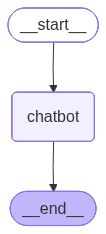

In [4]:
# グラフの可視化
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
# グラフの実行
response = graph.invoke({"messages": [("user", "光の三原色は？")]})

# 結果の表示
print(response)

{'messages': [HumanMessage(content='光の三原色は？', additional_kwargs={}, response_metadata={}, id='365b8f15-51c3-4be9-8511-6cae3098dc18'), AIMessage(content='光の三原色は、赤（Red）、緑（Green）、青（Blue）の3色です。これらの色を組み合わせることで、さまざまな色を表現することができます。この原理は、RGBカラーシステムとして知られ、ディスプレイや照明などで広く使用されています。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 76, 'prompt_tokens': 14, 'total_tokens': 90, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'finish_reason': 'stop', 'logprobs': None}, id='run-7d1e389f-7bde-4ace-9d8a-8705b9b30168-0', usage_metadata={'input_tokens': 14, 'output_tokens': 76, 'total_tokens': 90, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}


In [6]:
# 言語モデルからの回答のみを表示
print(response["messages"][-1].content)

光の三原色は、赤（Red）、緑（Green）、青（Blue）の3色です。これらの色を組み合わせることで、さまざまな色を表現することができます。この原理は、RGBカラーシステムとして知られ、ディスプレイや照明などで広く使用されています。


In [10]:
# グラフの実行と結果の表示
def stream_graph_updates(user_input: str):
    # 結果をストリーミングで得る
    events = graph.stream({"messages": [("user", user_input)]})
    for event in events:
        for value in event.values():
            print("回答:", value["messages"][-1].content, flush=True)

# チャットボットのループ
while True:
    user_input = input("質問:")
    if user_input.strip()=="":
        print("ありがとうございました!")
        break
    print("質問:", user_input, flush=True)
    stream_graph_updates(user_input)

質問: aで始まる英単語を5つ教えて
回答: もちろんです。「a」で始まる英単語を5つ挙げますね。

1. Apple（リンゴ）
2. Adventure（冒険）
3. Amazing（素晴らしい）
4. Artist（アーティスト）
5. Ant（アリ）

他にも知りたい単語があれば教えてください！
質問: 2つ目の単語は何を選んだ_
回答: 「2つ目の単語は何を選んだ」という質問ですが、具体的な文脈や選択肢がないため、どの単語を指しているのか分かりません。もう少し詳しく教えていただければ、より正確な回答ができるかと思います。
ありがとうございました!


In [8]:
from langgraph.checkpoint.memory import MemorySaver

# チェックポインタの作成
memory = MemorySaver()

# 記憶を持つ実行可能なステートグラフの作成
memory_graph = graph_builder.compile(checkpointer=memory)

In [9]:
# グラフの実行と結果の表示
def stream_graph_updates(user_input: str):
    events = memory_graph.stream(
        {"messages": [("user", user_input)]},
        {"configurable": {"thread_id": "1"}},
        stream_mode="values")
    # 結果をストリーミングで得る
    for event in events:
        print(event["messages"][-1].content, flush=True)

# チャットボットのループ
while True:
    user_input = input("質問:")
    if user_input.strip()=="":
        print("ありがとうございました!")
        break
    stream_graph_updates(user_input)

こんにちは！
こんにちは！どういったことをお話ししましょうか？
aで始まる英単語を5つ教えて
もちろんです！以下は「a」で始まる英単語の例です：

1. Apple（リンゴ）
2. Amazing（驚くべき）
3. Adventure（冒険）
4. Artist（アーティスト）
5. Animal（動物）

他にも知りたい単語があれば教えてください！
2つ目の単語は何にした？
2つ目の単語は「Amazing（驚くべき）」でした。何か他に知りたいことがあれば教えてください！
ありがとうございました!
